# TitanicKaggle
Titanic Machine Learning Challenge from Kaggle

From: https://www.kaggle.com/c/titanic

## Competition Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

### Practice Skills
Binary classification
Python and R basics

### Overview
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Import Modules and Data

In [1]:
# %% Import Modules

import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from itertools import compress, product
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# %% Import Data

train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")


### Data Exploration

Here, I want to explore some basic characteristics of the dataset: population, number of survivors, characteristics of the survivors. Based on popular belief (i.e. prioritization of women and children), I predict that the passenger's sex, age, and class will play a large role in whether or not an individual survived.

In [3]:
cols = list(train_data.columns.values)
print(cols)

print(train_data.head())
print(test_data.head())

sex = train_data.groupby("Sex").count()
print("\nCount of People\n",sex["Embarked"])

survived = train_data["Survived"].sum()
print("\nNumber of survivors:", survived)

survived_sex = train_data.groupby("Sex").sum()
print("\nNumber of survivors by sex:\n", survived_sex["Survived"])

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN   

### Data Cleaning and Prep


Now I want to clean and prepare the data for use in the machine learning algorithms: removing/replacing NaN and empty data, removing columns that are not useful or useable.

The removed features:
* Name: A person's name most likely has no quantifiable impact on survivability.
* Cabin: Due to the amount of missing/empty data, will not be used.
* Ticket: Ticket number is likely in order of the purchase of ticket, not indicative of personal characters.
* Fare: Like ticket, the cost of a ticket is not the feature of a person.
* Embarked: Location from which a person embarked does not matter in a survival setting.
* PassengerID: Merely an identifying value for a passenger, not something that would be used to determine survival.

Used features:
* Age: Likely to have been used, primarily for determination of children for prioritization of evacuation.
* Sex: A common belief that women and children were prioritized.
* Pclass: Ticket class may have played a role in higher class persons boarding life boats.
* SibSp: Number of siblings aboard may have higher values for children in families, and so could be a useful feature.
* Parch: Number of parents/children would have higher values for families, and likely families would try to stay together.

In [4]:
# copy data so that making any mistake only needs to re-copy the original data, and not re-import all data.
training = train_data

# Map strings for female and male to 0 and 1
mapping = {"female" : 0, "male" : 1}
training = training.replace(mapping)

# Fill Age NaNs with 0, as Age may be a good predictor
training["Age"] = training["Age"].fillna(0)

# Separate survived column into its own data
survived = training["Survived"]
training = training.drop("Survived", axis = 1)

# Desired features for analysis
cols = ["Pclass", "Sex", "Age", "SibSp", "Parch"]
print(cols)

# Get combinations of desired features

def combinations(items):
    return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )

combos = list(combinations(cols))
del combos[0]

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']


## Multinomial Naive Bayes

First I will implement Multinomial Naive Bayes, a good starting point as it is fairly simplistic, has good performance, and is a popular algorithm for categorization. The algorithm applies Bayes' Theorem with the naive assumption of independence between features.

In [5]:
def multinb(x, y):
    """
    
    This function performs the required functions for fitting and prediction a 
    Multinomial Naive Bayes
    from given x and y datasets.
    
    Args:
        x (array-like): independent data
        y (array-like): target data
        
    Return:
        score (float): Mean accuracy of the model on the given test and target 
        data
    
    """
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33,
                                                        random_state = 0)
    #X_train = np.array(X_train).reshape(-1,1)
    y_train = np.array(y_train).reshape(-1,1)
    #X_test = np.array(X_test).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    
    y_train.reshape(-1,1)
    
    # Fit and predict model
    multinb = MultinomialNB()
    multinb.fit(X_train, y_train.ravel())
    
    predicted = multinb.predict(X_test)
    predicted
    
    multinb.predict(X_test)
    score = multinb.score(X_test, y_test)
    
    # Plot
    # x_axis = range(len(X_test))
    #
    # fig,ax = plt.subplots(figsize=(15,10))
    # ax.scatter(x_axis, predicted, alpha = 0.3)
    # ax.scatter(x_axis, y_test, alpha = 0.3)
    
    return score


In [6]:
mnb_results = {}

for combo in combos:
    df = pd.DataFrame()
    
    for c in combo:
        df = pd.concat([df, training[c]], axis = 1)
    
    if len(c) > 1:
        separator = "-"
        joined = separator.join(combo)
    else:
        joined = combo
        
    score = multinb(df, survived)
    
    mnb_results[joined] = score

mnb_results_df = pd.DataFrame.from_dict(mnb_results, orient = "index")
print(mnb_results_df.sort_values(by=0, ascending = False))

                                   0
Age-Sex-Parch               0.732203
Age-Sex                     0.728814
Age-Sex-Parch-SibSp         0.722034
Age-Sex-Parch-Pclass        0.708475
Age-Sex-SibSp               0.701695
Parch-SibSp-Pclass-Sex-Age  0.691525
Age-Sex-Pclass              0.688136
Age-Sex-SibSp-Pclass        0.674576
Sex-Parch-SibSp-Pclass      0.674576
Sex-Parch                   0.674576
Sex-Parch-Pclass            0.674576
Sex-Parch-SibSp             0.661017
Parch-SibSp-Pclass          0.640678
Age-Pclass                  0.640678
Age-Parch-SibSp-Pclass      0.637288
Age-Parch-SibSp             0.633898
Parch-SibSp                 0.633898
Parch-Pclass                0.630508
Age-Parch-Pclass            0.630508
Age-SibSp-Pclass            0.623729
Sex-Pclass                  0.623729
Parch                       0.623729
SibSp-Pclass                0.623729
SibSp                       0.623729
Sex                         0.623729
Age-SibSp                   0.623729
A

### Multinomial Naive Bayes Results

From the above, we see that generally, Multinomial Naive Bayes doesn't have very great scores, no matter what combination of the desired features. The highest score achieved is 0.732 using Sex, Parch, and Age, which mostly agrees with my hypothesis and Sex and Age would be the largest factors. Parch also makes sense, as number of parents/children would indicate families, most likely to stay together and survive (or not) together, or mother-child groups prioritized to survive.

### ROC Curve for Multinomial Naive Bayes

In [7]:
# Compute ROC curve and ROC area for best model

best_mnb = ["Sex", "Parch", "Age"]
best_df = pd.DataFrame()
for b in best_mnb:
    best_df = pd.concat([best_df, training[b]], axis = 1)

# Need the y_test data and prediction probabilities
X_train, X_test, y_train, y_test = train_test_split(best_df, survived, test_size = 0.33, random_state = 0)

# Fit and get prediction probabilities
multinb = MultinomialNB()
predict_prob = multinb.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, predict_prob[:,1])
roc_auc = auc(fpr, tpr)

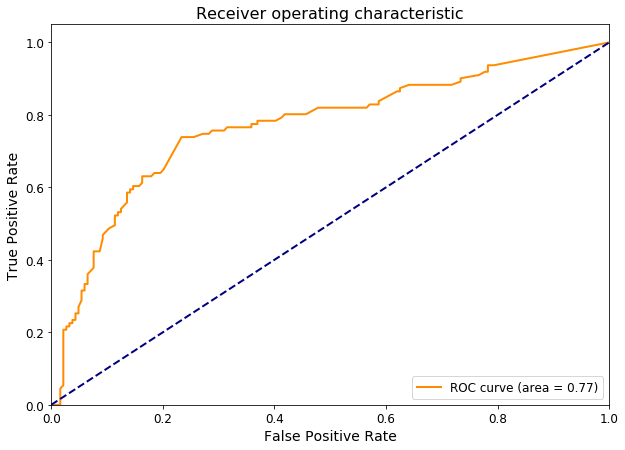

In [8]:
fig,ax = plt.subplots(figsize=(10,7))
lw = 2
ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver operating characteristic', fontsize=16)
ax.legend(loc="lower right", fontsize=12)
ax.tick_params(axis="both", labelsize=12)

Here, the ROC curve provides a much better illustration of the predictive ability than just the score value. Ideally, we want very high values in the very beginning, with the area of the curve as close to 1 as possible.

## Random Forests

Now I will move on to implementing Random Forests, an ensemble model relying on bootstrap aggregation, using a different random subset for each model in the ensemble. 

For consistency, I will be using the same set of features as with Multinomial Naive Bayes.

In [34]:
def random_forest(x, y, d):
    """
    
    This function performs the required functions for fitting and prediction a Logistic Regression model
    from given x and y datasets.
    
    Args:
        x (array-like): independent data
        y (array-like): target data
        
    Return:
        score (float): Mean accuracy of the model on the given test and target data
    
    """
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 0)
    
    # Fit and predict model
    rf = RandomForestClassifier(max_depth=d, random_state=0)
    rf.fit(X_train, y_train)
    
    predicted = rf.predict(X_test)
    predicted
    
    rf.predict(X_test)
    score = rf.score(X_test, y_test)
    
    return score

As Random Forests has a depth variable, I want to determine the best depth to use. Thus, the below will loop through depths from 2 to 10, 10 being arbitrarily chosen as the deepest I want the tree to be.

In [82]:
old_max = 0
new_max = 0

for d in range(2,11):
    rf_results = {}

    for combo in combos:
        #try:
        df = pd.DataFrame()

        for c in combo:
            df = pd.concat([df, training[c]], axis = 1)

        if len(c) > 1:
            separator = "-"
            joined = separator.join(combo)
        else:
            joined = combo

        score = random_forest(df, survived, d)

        rf_results[joined] = score

    rf_results_df = pd.DataFrame.from_dict(rf_results, orient = "index")
    rf_results_max = rf_results_df[0].argmax()
    rf_max_score = rf_results_df[rf_results_df.index.str.startswith(rf_results_max)][0][rf_results_max]
    print(rf_max_score)
    
    if rf_max_score > old_max:
        old_max = rf_max_score
        new_max = d
        
print(new_max)


0.7966101694915254
0.8067796610169492
0.8135593220338984
0.8169491525423729
0.8271186440677966
0.823728813559322
0.8169491525423729
0.8067796610169492
0.7932203389830509
6


In [84]:
rf_results = {}

for combo in combos:
    #try:
    df = pd.DataFrame()

    for c in combo:
        df = pd.concat([df, training[c]], axis = 1)

    if len(c) > 1:
        separator = "-"
        joined = separator.join(combo)
    else:
        joined = combo

    score = random_forest(df, survived, new_max)

    rf_results[joined] = score

rf_results_df = pd.DataFrame.from_dict(rf_results, orient = "index")
print(rf_results_df.sort_values(by=0, ascending = False))

                                   0
Age-Sex-SibSp-Pclass        0.827119
Age-Sex-Parch-SibSp         0.820339
Parch-SibSp-Pclass-Sex-Age  0.816949
Age-Sex-SibSp               0.810169
Age-Sex-Parch-Pclass        0.806780
Age-Sex-Parch               0.796610
Sex-SibSp-Pclass            0.796610
Age-Sex-Pclass              0.793220
Sex-Parch-Pclass            0.789831
Sex-Parch-SibSp-Pclass      0.789831
Sex-SibSp                   0.789831
Sex-Parch                   0.786441
Age-Sex                     0.783051
Sex-Pclass                  0.783051
Sex                         0.783051
Sex-Parch-SibSp             0.776271
Age-SibSp-Pclass            0.718644
Parch-Pclass                0.711864
Age-Parch-SibSp-Pclass      0.708475
Age-Parch-Pclass            0.705085
Parch-SibSp-Pclass          0.701695
SibSp-Pclass                0.684746
Age-SibSp                   0.684746
Pclass                      0.681356
Age-Pclass                  0.674576
Age-Parch-SibSp             0.650847
P

### Random Forest Results

Here, we see high scores than with Multinomial Naive Bayes, and even over 80%, with a score of 0.827 with Age, Sex, SibSp, and Pclass. We still see that Age and Sex are features that are included in the combination of features with the best score.